### Design the State Variables 6

For our robot we will maintain the position and orientation:

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta\end{bmatrix}^\mathsf{T}$$


The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity 

$$\mathbf{u} = \begin{bmatrix} \dot x & \dot y & w\end{bmatrix}^\mathsf{T}$$

In [5]:
from math import sin, cos
import numpy as np
from threading import Timer

class InputOutputLinearization:
    def __init__(self, robot, estimator, **kwargs):
        self.robot = robot
        self.estimator = estimator
        self.timer = None
        self.trajectory_timers = []
        self.desired_position = None
        self._desired_speed = None
        self.goal_reached = False
        self.current_point_index = 0
        self.trajectory_points = None
        self.dt = 0
        
        self.f_s = kwargs.get('f_s', 100)
        self.b = kwargs.get('b', 0.05)
        self.k1 = kwargs.get('k1', 1)
        self.k2 = kwargs.get('k2', 1)
        self.epsilon = kwargs.get('epsilon', 0.025)        
        
    def compute_control_input(self, state, des_position, des_speed):
        x, y, theta = state
        y1 = x + self.b * cos(theta)
        y2 = y + self.b * sin(theta)
        y1_d, y2_d = des_position
        y1_dot_d, y2_dot_d = des_speed

        u1 = y1_dot_d + self.k1 * (y1_d - y1)
        u2 = y2_dot_d + self.k2 * (y2_d - y2)

        T = np.array([[np.cos(theta), -self.b*np.sin(theta)],
                      [np.sin(theta), self.b*np.cos(theta)]])
        T_inv = np.linalg.inv(T)
        v, omega = np.dot(T_inv, np.array([u1, u2]))
        
        return v, omega / 2
    
    def compute_desired_speed(self):
        dx = self.desired_position[0] - self.estimator.position[0]
        dy = self.desired_position[1] - self.estimator.position[1]
        theta = np.arctan2(dy, dx)
        speed = [self.robot.max_vel * cos(theta), self.robot.max_vel * sin(theta)]
        return speed
        
    def execute_trajectory(self, trajectory_points, dt=1):
        self.trajectory_timers = []
        for index, point in enumerate(trajectory_points):
            timer = Timer(dt * index, self.go, args=[point])
            self.trajectory_timers.append(timer)
            timer.start()



In [2]:
from trajectory_planning.trajectory_planner import *

fs=100

path = [(-.6, -.7), (-.6, 0), (-.4, .6), (0, .5), (0, -.2), (-.2, -.6), (.3, -.5), (.3, .6), (.6, .4)]
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=TRAP_VEL_PROF)
dt=1/fs
print(x_des)



(-0.6, -0.6000000000008036, -0.6000000000128586, -0.6000000000650952, -0.60000000020573, -0.6000000005022601, -0.6000000010414605, -0.6000000019293777, -0.6000000032913219, -0.6000000052718593, -0.6000000080348018, -0.600000011763196, -0.6000000166593118, -0.6000000229446267, -0.6000000308598121, -0.6000000406647182, -0.600000052638353, -0.6000000670788664, -0.6000000843035296, -0.6000001046487116, -0.6000001284698584, -0.6000001561414686, -0.6000001880570669, -0.6000002246291782, -0.6000002662892993, -0.6000003134878699, -0.6000003666942413, -0.600000426396645, -0.6000004931021586, -0.6000005673366734, -0.6000006496448552, -0.6000007405901099, -0.6000008407545435, -0.6000009507389239, -0.6000010711626371, -0.6000012026636476, -0.600001345898453, -0.6000015015420399, -0.6000016702878371, -0.6000018528476682, -0.6000020499517017, -0.600002262348403, -0.6000024908044805, -0.6000027361048346, -0.600002999052502, -0.6000032804686014, -0.6000035811922765, -0.6000039020806371, -0.60000424400

-0.65
-0.6500000019300562
-0.5932128746310026
-0.5340248735258878
-0.47008315609868145
-0.4017650486673568
-0.3294397913945376
-0.25368764223941775
-0.17528931856496555
-0.09521095116511687
-0.014568899007757088
0.06542406278473586
0.14352713170494083
0.21854722572833343
0.28941282719724964
0.35523641286955593
0.415357746658638
0.46936372995099335
0.5170846351686984
0.5585702961162469
0.5940523256799193
0.6238993061916307
0.6485713058667476
0.6685785243103647
0.6844469669002059
0.696692286616368
0.7058015979447696
0.7122222422727197
0.7163561092065004
0.7185580701419431
0.7191372285712443
0.7183599295786006
0.716453726484501
0.7136117345978524
0.7099969925719434
0.7057465975057021
0.7009754849637881
0.6957797969093228
0.6902398270072816
0.6844225608604962
0.6783838441406426
0.6721702185641415
0.6658204673400533
0.6593669102400094
0.6528364852542451
0.6462516498363484
0.6396311305798815
0.6329905461499793
0.6263429245926918
0.61969913284491
0.6130682333883966
0.6064577805179733
0.599874

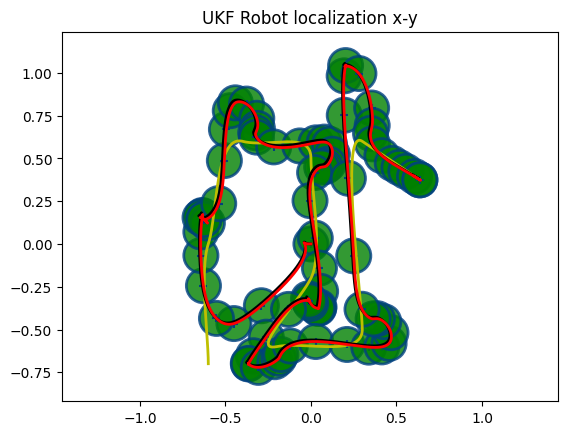

(-0.6, -0.6000000000008036, -0.6000000000128586, -0.6000000000650952, -0.60000000020573, -0.6000000005022601, -0.6000000010414605, -0.6000000019293777, -0.6000000032913219, -0.6000000052718593, -0.6000000080348018, -0.600000011763196, -0.6000000166593118, -0.6000000229446267, -0.6000000308598121, -0.6000000406647182, -0.600000052638353, -0.6000000670788664, -0.6000000843035296, -0.6000001046487116, -0.6000001284698584, -0.6000001561414686, -0.6000001880570669, -0.6000002246291782, -0.6000002662892993, -0.6000003134878699, -0.6000003666942413, -0.600000426396645, -0.6000004931021586, -0.6000005673366734, -0.6000006496448552, -0.6000007405901099, -0.6000008407545435, -0.6000009507389239, -0.6000010711626371, -0.6000012026636476, -0.600001345898453, -0.6000015015420399, -0.6000016702878371, -0.6000018528476682, -0.6000020499517017, -0.600002262348403, -0.6000024908044805, -0.6000027361048346, -0.600002999052502, -0.6000032804686014, -0.6000035811922765, -0.6000039020806371, -0.60000424400

In [6]:
from scipy.linalg import inv,block_diag
from filterpy.common import Q_discrete_white_noise
from math import tan, sin, cos, sqrt, atan2
from numpy.random import normal, randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.stats import plot_covariance

R_var = 0.01
Q_var = 0.01
x = np.array([0.,0.,0.,0.,0.,0.]).T
P = np.diag([.01,.01,.01,.01,.01,.01])
F = np.array([[1, dt, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 1, dt, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, dt],
              [0, 0, 0, 0, 0, 0]])
B = np.array([[0, 0 ,0],
              [1, 0 ,0],
              [0, 0 ,0],
              [0, 1 ,0],
              [0, 0 ,0],
              [0, 0 ,1]])
H = B.T
R = np.diag([R_var,R_var,R_var])
Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=Q_var), Q_discrete_white_noise(2, dt=dt, var=Q_var), Q_discrete_white_noise(2, dt=dt, var=Q_var))

def move_real(x, dt, u,v_std,w_std):
    v_act = u[0]# + randn()*v_std
    w_act = u[1]# + randn()*w_std
    theta = x[4]
    x[5]=w
    x[1]=v * cos(theta)
    x[3]=v * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v_act,w_act],dt)

    return x 

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    # Derivate del sistema
    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state


controller=InputOutputLinearization(0,runge_kutta)
sim_pos=x
xs, cov = [], []
track=[]
plt.figure()

for i in range(len(x_des)):
    
    v,w=controller.compute_control_input([x[0],x[2],x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(x[4]),v*sin(x[4]),w]

    print(v)
    # predict
    x = F @ x + B @ u
    P = F @ P @ F.T + Q

    if i%100==0:
        cova =np.diag([P[0,0],P[2,2]])
        cova[0,1]=P[0,2]
        cova[1,0]=P[2,0]
        plot_covariance((x[0], x[2]), cov=cova,facecolor='g', alpha=0.8) 

    for i in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=.01, w_std=.01)
        track.append(list(sim_pos))  

    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])

    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    if i%10==0:
        cova =np.diag([P[0,0],P[2,2]])
        cova[0,1]=P[0,2]
        cova[1,0]=P[2,0]
        plot_covariance((x[0], x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
    xs.append(x)
    cov.append(P)
 
xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

plt.plot(x_des, y_des, color='y', lw=2)
plt.plot(track[:, 0], track[:,2], color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2], color='r', lw=2)
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()
print(x_des,y_des)
#plot_track(xs[:, 0], track, zs, cov, plot_P=False)

In [4]:
print(x_dot_des,y_dot_des)

(0.0, -1.2845679731132807e-09, -1.0276439523161863e-08, -3.4682396933962264e-08, -8.220817990389361e-08, -1.605579642531789e-07, -2.7743384060236057e-07, -4.4053529314239436e-07, -6.57558678274317e-07, -9.361967033353315e-07, -1.284137905336094e-06, -1.7090661296335895e-06, -2.2186600086448113e-06, -2.820592440536443e-06, -3.5225300679801468e-06, -4.332132756805833e-06, -5.257053074750153e-06, -6.304935770115369e-06, -7.483417250531443e-06, -8.80012506158771e-06, -1.0262677365638173e-05, -1.1878682420405172e-05, -1.3655738057769459e-05, -1.560143116244871e-05, -1.772333715064716e-05, -2.0029019448830923e-05, -2.252602897247046e-05, -2.522190360460665e-05, -2.812416767465208e-05, -3.124033143714674e-05, -3.457789055033127e-05, -3.814432555498909e-05, -4.194710135303561e-05, -4.599366668632119e-05, -5.029145361523557e-05, -5.484787699753116e-05, -5.967033396690873e-05, -6.476620341183311e-05, -7.01428454542008e-05, -7.580760092796935e-05, -8.176779085799855e-05, -8.80307159386346e-05, -9